# Particle Size Distribution
Notebook by Lukas Grünewald, [https://github.com/lukmuk/particle-size-distribution](https://github.com/lukmuk/particle-size-distribution).

## Purpose:
Evaluate (nano)particle (or other) size distribution by fitting a distribution function and extracting statistical parameters in Python.  
Requires `numpy`, `scipy`, and `pandas`. Additionally, the [uncertainties](https://pythonhosted.org/uncertainties/) package is used to handle error propagation.  

## Usage:
Segmentation and size measurements (e.g. areas, Feret diameters, ...) were extracted using *Fiji*.  
The `Results.csv` of the `Analyze particles...` function in *Fiji* is loaded here for analysis.  
Multiple `.csv` files can be loaded and stacked using `pandas`.  
To start, put the `.csv` files into the same folder with a copy of this notebook.

In the following example, particle/grain sizes of an SEM image were measured in *Fiji* using [ParticleSizer](https://imagej.net/plugins/particlesizer).  
The projected areas and the mininmum Feret diameters are taken as the size metric and a log-normal distribution is fitted to the histograms.

In [1]:
%load_ext watermark

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

from scipy.optimize import curve_fit

#For error propagation:
from uncertainties import ufloat, unumpy
from uncertainties.umath import *

In [3]:
#Print package versions
%watermark -i -v -u -m --iversions

Last updated: 2022-10-16T12:08:22.915201+02:00

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.5.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 5, GenuineIntel
CPU cores   : 16
Architecture: 64bit

pandas       : 1.4.3
uncertainties: 3.1.7
matplotlib   : 3.5.2
numpy        : 1.21.5



### Define a particle size distribution  
Here, we use a log-normal distribution (or probability density function, PDF) as an example.  
I tested other variants such as using [scipy.stats.lognorm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html) but the following approach gave me best results and easy access to the statistical fitting errors.

In [4]:
def pdf(x, mu, sigma):
    """Probability density function of a log-normal distribution"""
    return (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi)))

For a nice discussion about the [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution) in this context, see  
E. Limpert, W. A. Stahel, and M. Abbt, *BioScience*, **51**, 5,(2001) 341–352, doi: [10.1641/0006-3568(2001)051](https://doi.org/10.1641/0006-3568(2001)051[0341:LNDATS]2.0.CO;2). The above definition is

$$    {\displaystyle f(x)={\frac {1}{{\sqrt {2\pi }}\sigma x}}\,\exp {\Big (}-{\frac {(\ln(x)-\mu )^{2}}{2\sigma ^{2}}}{\Big )},\quad x>0}$$
with the mean $\mu$ and standard deviation $\sigma$ of $\ln(x)$ as fit parameters.

### Properties for the log-normal distribution 
We calculate the mode $M$, median $m$, arithmetic mean $\mu_\text{a}$, and standard deviation $\sigma_\text{a}$ for the measured values $x$ from the fitted $\mu$ and $\sigma$ parameters.  
Statistical fitting errors on $\mu$ and $\sigma$ will be propagated by the ``uncertainties`` [package](https://pythonhosted.org/uncertainties/).
$$M(x)=e^{\mu -\sigma ^{2}}$$
$$m(x)=e^{\mu}$$
$$\mu_\text{a}(x)=e^{\mu + \frac{\sigma ^{2}}{2}}$$
$$\sigma_\text{a}(x)=e^{\mu +{\tfrac {1}{2}}\sigma ^{2}}{\sqrt {e^{\sigma ^{2}}-1}}$$

#### Scatter intervals

For a log-normal distribution, with geometric mean and standard deviation $\mu^{∗}=e^\mu$ and $\sigma^{∗} = e^\sigma$, 
$$[ \mu^{∗}/ \sigma^{∗} , \mu^{∗}\cdot\sigma^{∗} ]$$
contains 68 %, and 
$$[ \mu^{∗}/ \left(\sigma^{∗}\right)^2 , \mu^{∗}\cdot\left(\sigma^{∗}\right)^2 ]$$ 
contains 95 % of the probability.

## Load and inspect data

Load the data:

In [5]:
# Grab and stack all csv files in working directory in a pandas data frame
df = pd.concat([pd.read_csv(filename, header=0, index_col=None) for filename in glob.glob('*.csv')], ignore_index=True)

In [6]:
df.shape

(2313, 27)

In [7]:
print(f'Number of measured particles/grains: {df.shape[0]}')

Number of measured particles/grains: 2313


In [8]:
# Inspect data set
df.head()

,,Frame,Label,X,Y,Area,Area Conv. Hull,Peri.,Peri. Conv. Hull,Feret,...,Circ.,Elong.,Convexity,Solidity,Num. of Holes,Thinnes Rt.,Contour Temp.,Orientation,Fract. Dim.,Fract. Dim. Goodness
0,1,1,1,5212.984,58.421,17268.571,17565.719,484.196,492.264,188.315,...,13.576,0.575,1.0,0.983,0,0.926,0.145,8.018,1.624,0.992
1,2,1,2,2357.451,42.488,3744.071,3803.500,209.429,215.342,74.912,...,11.715,0.349,1.0,0.984,0,1.000,0.163,167.523,1.485,0.964
2,3,1,3,4118.055,62.085,6732.535,6868.374,303.054,305.301,118.321,...,13.641,0.631,1.0,0.980,0,0.921,0.124,60.433,1.582,0.992
3,4,1,4,1474.562,43.515,3226.183,3319.573,199.627,203.314,76.483,...,12.352,0.512,1.0,0.972,0,1.000,0.148,132.645,1.432,0.951
4,5,1,5,2183.952,69.811,7640.960,7802.270,346.958,350.991,146.153,...,15.755,0.717,1.0,0.979,0,0.798,0.135,64.133,1.623,0.991


### Metric: Area-Equivalent Circle Diameter
An often used metric is the area-equivalent circle diameter.  
We calculate circles with equal size as the measured projected particle/grain size (``Area`` column).

In [9]:
data = df['Area'].to_numpy()

Calculate area-equivalent diameters from areas: $${\displaystyle d_{p}={\sqrt {\frac {4A}{\pi }}}.}$$

In [10]:
data = np.sqrt(4*data/np.pi)

The next cell, plots the histogram, performs a fit of the (log-normal) distribution, and displays/saves the result.  

Mode:		 72.2+/-1.2
Median:		 86.6+/-1.1
Mean:		 94.9+/-1.3
Std. dev.:	 42.4+/-1.5
68% conf. intervall: 57.0+/-1.0 to 133.0+/-2.0
95% conf. intervall: 37.0+/-1.0 to 203.0+/-5.0


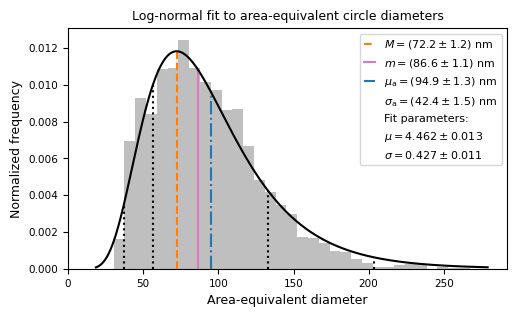

In [11]:
# Create plot
fig, ax = plt.subplots(figsize=(5, 3))

# Normalized histogram
n, bins, patches = ax.hist(data, bins='auto', density=True, facecolor = 'grey', alpha = 0.5, label=None)
centers = (0.5*(bins[1:]+bins[:-1]))

# Fit of pdf
pars, cov = curve_fit(pdf, centers, n)

# Draw pdf
pdfcol ='k'
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 1000)
ax.plot(x, pdf(x, *pars), pdfcol , linewidth = 1.5, label=None, zorder=10)

# Add fit parameters (mu, sigma, mode) as labels
# Errors are from diagonal elements of cov (covariance matrix) --> sqrt(Var)=Std dev
mu, sigma = unumpy.uarray(pars, np.sqrt(np.diag(cov)))

muStar = exp(mu)
sigStar = exp(sigma)
confidence68 = (muStar/sigStar, muStar*sigStar) 
confidence95 = (muStar/sigStar**2, muStar*sigStar**2) 

mode = exp(mu - sigma ** 2)
median = exp(mu)
mean = exp(mu + sigma ** 2 / 2)
std = exp(mu + sigma**2/2) * sqrt(exp(sigma**2)-1)

print(f'Mode:\t\t {mode}')
print(f'Median:\t\t {median}')
print(f'Mean:\t\t {mean}')
print(f'Std. dev.:\t {std}')
print(f'68% conf. intervall: {np.round(confidence68[0].nominal_value)}+/-{np.round(confidence68[0].std_dev)} to {np.round(confidence68[1].nominal_value)}+/-{np.round(confidence68[1].std_dev)}')
print(f'95% conf. intervall: {np.round(confidence95[0].nominal_value)}+/-{np.round(confidence95[0].std_dev)} to {np.round(confidence95[1].nominal_value)}+/-{np.round(confidence95[1].std_dev)}')

# Plot labels
lb_std = rf'$\sigma_\mathregular{{a}} = ({np.round(std.nominal_value,1)} \pm {np.round(std.std_dev,1)})$ nm'
lb_mean = rf'$\mu_\mathregular{{a}} = ({np.round(mean.nominal_value,1)} \pm {np.round(mean.std_dev,1)})$ nm'
lb_mode = rf'$M = ({np.round(mode.nominal_value,1)} \pm {np.round(mode.std_dev,1)})$ nm'
lb_median = rf'$m = ({np.round(median.nominal_value,1)} \pm {np.round(median.std_dev,1)})$ nm'
lb_mu = f'$\mu = {np.round(mu.nominal_value,3)} \pm {np.round(mu.std_dev,3)}$'
lb_sig = f'$\sigma = {np.round(sigma.nominal_value,3)} \pm {np.round(sigma.std_dev,3)}$'

# Add vertical markers for positions of calculated properties
# Mode
ax.plot([mode.nominal_value, mode.nominal_value], [0, pdf(mode.nominal_value, *pars)], c='tab:orange', ls='--', label=lb_mode)

# Median
ax.plot([median.nominal_value, median.nominal_value], [0, pdf(median.nominal_value, *pars)], c='tab:pink', ls='-', label=lb_median)

# Mean
ax.plot([mean.nominal_value, mean.nominal_value], [0, pdf(mean.nominal_value, *pars)], c='tab:blue', ls='-.', label=lb_mean)

# Confidence intervall 68%
ci = confidence68
ax.plot([ci[0].nominal_value, ci[0].nominal_value], [0, pdf(ci[0].nominal_value, *pars)], c=pdfcol, ls='dotted')
ax.plot([ci[1].nominal_value, ci[1].nominal_value], [0, pdf(ci[1].nominal_value, *pars)], c=pdfcol, ls='dotted')

# Confidence intervall 95%
ci = confidence95
ax.plot([ci[0].nominal_value, ci[0].nominal_value], [0, pdf(ci[0].nominal_value, *pars)], c=pdfcol, ls='dotted')
ax.plot([ci[1].nominal_value, ci[1].nominal_value], [0, pdf(ci[1].nominal_value, *pars)], c=pdfcol, ls='dotted')

# Gemerate empty plots, so that fit parameters are added in legend
plt.plot([], [], ' ', label=lb_std)
plt.plot([], [], ' ', label='Fit parameters:')
plt.plot([], [], ' ', label=lb_mu)
plt.plot([], [], ' ', label=lb_sig)

# Cosmetics 
ax.set_title(f'Log-normal fit to area-equivalent circle diameters', fontsize=9)
ax.set_xlabel('Area-equivalent diameter', fontsize=9)
ax.set_ylabel("Normalized frequency", fontsize=9)
plt.tick_params(axis='both', which='major', labelsize=7.5)

ax.set_xlim(0,)
#ax.set_ylim(0, np.max(pdf(x, *pars))*1.8)

ax.legend(loc='best', handlelength=1, fontsize=8, ncol=1, columnspacing=0.1)
plt.tight_layout(pad=0.1)
fig.savefig('plots/AreaEquivalentCircleDiameter_normalized.pdf', pad_inches=0)

### Metric:  Minimum Feret Diameter
We can fit to another size metric from the pandas table by adjusting the `data` variable.
Here, we switch to the minimum Feret diameter:

In [12]:
data = df['Min. Feret'].to_numpy()

Mode:		 59.3+/-0.9
Median:		 71.9+/-0.8
Mean:		 79.2+/-1.0
Std. dev.:	 36.6+/-1.2
68% conf. intervall: 46.0+/-1.0 to 112.0+/-2.0
95% conf. intervall: 30.0+/-1.0 to 173.0+/-4.0


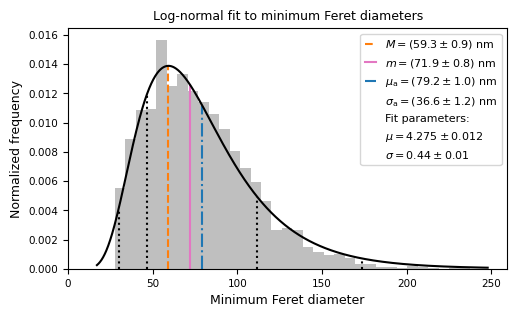

In [13]:
# Create plot
fig, ax = plt.subplots(figsize=(5, 3))

# Normalized histogram
n, bins, patches = ax.hist(data, bins='auto', density=True, facecolor = 'grey', alpha = 0.5, label=None)
centers = (0.5*(bins[1:]+bins[:-1]))

# Fit of pdf
pars, cov = curve_fit(pdf, centers, n)

# Draw pdf
pdfcol ='k'
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 1000)
ax.plot(x, pdf(x, *pars), pdfcol , linewidth = 1.5, label=None, zorder=10)

# Add fit parameters (mu, sigma, mode) as labels
# Errors are from diagonal elements of cov (covariance matrix) --> sqrt(Var)=Std dev
mu, sigma = unumpy.uarray(pars, np.sqrt(np.diag(cov)))

muStar = exp(mu)
sigStar = exp(sigma)
confidence68 = (muStar/sigStar, muStar*sigStar) 
confidence95 = (muStar/sigStar**2, muStar*sigStar**2) 

mode = exp(mu - sigma ** 2)
median = exp(mu)
mean = exp(mu + sigma ** 2 / 2)
std = exp(mu + sigma**2/2) * sqrt(exp(sigma**2)-1)

print(f'Mode:\t\t {mode}')
print(f'Median:\t\t {median}')
print(f'Mean:\t\t {mean}')
print(f'Std. dev.:\t {std}')
print(f'68% conf. intervall: {np.round(confidence68[0].nominal_value)}+/-{np.round(confidence68[0].std_dev)} to {np.round(confidence68[1].nominal_value)}+/-{np.round(confidence68[1].std_dev)}')
print(f'95% conf. intervall: {np.round(confidence95[0].nominal_value)}+/-{np.round(confidence95[0].std_dev)} to {np.round(confidence95[1].nominal_value)}+/-{np.round(confidence95[1].std_dev)}')

# Plot labels
lb_std = rf'$\sigma_\mathregular{{a}} = ({np.round(std.nominal_value,1)} \pm {np.round(std.std_dev,1)})$ nm'
lb_mean = rf'$\mu_\mathregular{{a}} = ({np.round(mean.nominal_value,1)} \pm {np.round(mean.std_dev,1)})$ nm'
lb_mode = rf'$M = ({np.round(mode.nominal_value,1)} \pm {np.round(mode.std_dev,1)})$ nm'
lb_median = rf'$m = ({np.round(median.nominal_value,1)} \pm {np.round(median.std_dev,1)})$ nm'
lb_mu = f'$\mu = {np.round(mu.nominal_value,3)} \pm {np.round(mu.std_dev,3)}$'
lb_sig = f'$\sigma = {np.round(sigma.nominal_value,3)} \pm {np.round(sigma.std_dev,3)}$'

# Add vertical markers for positions of calculated properties
# Mode
ax.plot([mode.nominal_value, mode.nominal_value], [0, pdf(mode.nominal_value, *pars)], c='tab:orange', ls='--', label=lb_mode)

# Median
ax.plot([median.nominal_value, median.nominal_value], [0, pdf(median.nominal_value, *pars)], c='tab:pink', ls='-', label=lb_median)

# Mean
ax.plot([mean.nominal_value, mean.nominal_value], [0, pdf(mean.nominal_value, *pars)], c='tab:blue', ls='-.', label=lb_mean)

# Confidence intervall 68%
ci = confidence68
ax.plot([ci[0].nominal_value, ci[0].nominal_value], [0, pdf(ci[0].nominal_value, *pars)], c=pdfcol, ls='dotted')
ax.plot([ci[1].nominal_value, ci[1].nominal_value], [0, pdf(ci[1].nominal_value, *pars)], c=pdfcol, ls='dotted')

# Confidence intervall 95%
ci = confidence95
ax.plot([ci[0].nominal_value, ci[0].nominal_value], [0, pdf(ci[0].nominal_value, *pars)], c=pdfcol, ls='dotted')
ax.plot([ci[1].nominal_value, ci[1].nominal_value], [0, pdf(ci[1].nominal_value, *pars)], c=pdfcol, ls='dotted')

# Gemerate empty plots, so that fit parameters are added in legend
plt.plot([], [], ' ', label=lb_std)
plt.plot([], [], ' ', label='Fit parameters:')
plt.plot([], [], ' ', label=lb_mu)
plt.plot([], [], ' ', label=lb_sig)

# Cosmetics 
ax.set_title(f'Log-normal fit to minimum Feret diameters', fontsize=9)
ax.set_xlabel('Minimum Feret diameter', fontsize=9)
ax.set_ylabel("Normalized frequency", fontsize=9)
plt.tick_params(axis='both', which='major', labelsize=7.5)

ax.set_xlim(0,)
#ax.set_ylim(0, np.max(pdf(x, *pars))*1.8)

ax.legend(loc='best', handlelength=1, fontsize=8, ncol=1, columnspacing=0.1)
plt.tight_layout(pad=0.1)
fig.savefig('plots/MinFeretDiameter_normalized.pdf', pad_inches=0)

### Plot with absolute values on $y$-axis instead of normalized values  
The above distributions show the normalized histograms (`density=True` keyword) and the fraction on the $y$ axis.  
Alternatively, the absolute values (the actual number of counted grains/particles in the histogram bins) can also be displayed.  
This is done by  
  - Fitting the distribution to the normalized values (then we do not need to fit a scaling factor as another fit parameter)
  - Plotting the histogram with absolute frequencies (`density=False`)
  - Use a scaling factor to scale up the fitted distribution (taken from [here](https://stackoverflow.com/questions/41024455/histogram-with-non-normalized-fit-line-matplotlib))

Mode:		 59.3+/-0.9
Median:		 71.9+/-0.8
Mean:		 79.2+/-1.0
Std. dev.:	 36.6+/-1.2
68% conf. intervall: 46.0+/-1.0 to 112.0+/-2.0
95% conf. intervall: 30.0+/-1.0 to 173.0+/-4.0


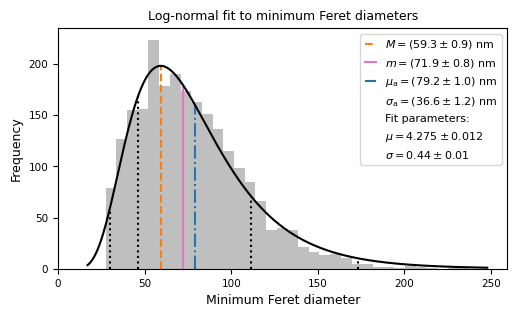

In [14]:
# Create plot
fig, ax = plt.subplots(figsize=(5, 3))

# Fit distribution using normalized histogram
n2, bins2, patches2 = ax.hist(data, bins='auto', density=True, facecolor = 'grey', alpha = 0, label=None)
centers2 = (0.5*(bins[1:]+bins[:-1]))
pars, cov = curve_fit(pdf, centers2, n2)

# Plot histogram with absolute values, i.e. density=False
n, bins, patches = ax.hist(data, bins='auto', density=False, facecolor = 'grey', alpha = 0.5, label=None)
centers = (0.5*(bins[1:]+bins[:-1]))

# Scaling factor for distribution
# https://stackoverflow.com/questions/41024455/histogram-with-non-normalized-fit-line-matplotlib
scaling_factor = sum(n * np.diff(bins))

# Draw pdf
pdfcol ='k'
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 1000)
ax.plot(x, pdf(x, *pars)*scaling_factor, pdfcol, linewidth = 1.5, label=None, zorder=100)

# Add fit parameters (mu, sigma, mode) as labels
# Errors are from diagonal elements of cov (covariance matrix) --> sqrt(Var)=Std dev
mu, sigma = unumpy.uarray(pars, np.sqrt(np.diag(cov)))

muStar = exp(mu)
sigStar = exp(sigma)
confidence68 = (muStar/sigStar, muStar*sigStar) 
confidence95 = (muStar/sigStar**2, muStar*sigStar**2) 

mode = exp(mu - sigma ** 2)
median = exp(mu)
mean = exp(mu + sigma ** 2 / 2)
std = exp(mu + sigma**2/2) * sqrt(exp(sigma**2)-1)

print(f'Mode:\t\t {mode}')
print(f'Median:\t\t {median}')
print(f'Mean:\t\t {mean}')
print(f'Std. dev.:\t {std}')
print(f'68% conf. intervall: {np.round(confidence68[0].nominal_value)}+/-{np.round(confidence68[0].std_dev)} to {np.round(confidence68[1].nominal_value)}+/-{np.round(confidence68[1].std_dev)}')
print(f'95% conf. intervall: {np.round(confidence95[0].nominal_value)}+/-{np.round(confidence95[0].std_dev)} to {np.round(confidence95[1].nominal_value)}+/-{np.round(confidence95[1].std_dev)}')

# Plot labels
lb_std = rf'$\sigma_\mathregular{{a}} = ({np.round(std.nominal_value,1)} \pm {np.round(std.std_dev,1)})$ nm'
lb_mean = rf'$\mu_\mathregular{{a}} = ({np.round(mean.nominal_value,1)} \pm {np.round(mean.std_dev,1)})$ nm'
lb_mode = rf'$M = ({np.round(mode.nominal_value,1)} \pm {np.round(mode.std_dev,1)})$ nm'
lb_median = rf'$m = ({np.round(median.nominal_value,1)} \pm {np.round(median.std_dev,1)})$ nm'
lb_mu = f'$\mu = {np.round(mu.nominal_value,3)} \pm {np.round(mu.std_dev,3)}$'
lb_sig = f'$\sigma = {np.round(sigma.nominal_value,3)} \pm {np.round(sigma.std_dev,3)}$'

# Add vertical markers for positions of calculated properties
# Mode
ax.plot([mode.nominal_value, mode.nominal_value], [0, pdf(mode.nominal_value, *pars)*scaling_factor], c='tab:orange', ls='--', label=lb_mode)

# Median
ax.plot([median.nominal_value, median.nominal_value], [0, pdf(median.nominal_value, *pars)*scaling_factor], c='tab:pink', ls='-', label=lb_median)

# Mean
ax.plot([mean.nominal_value, mean.nominal_value], [0, pdf(mean.nominal_value, *pars)*scaling_factor], c='tab:blue', ls='-.', label=lb_mean)

# Confidence intervall 68%
ci = confidence68
ax.plot([ci[0].nominal_value, ci[0].nominal_value], [0, pdf(ci[0].nominal_value, *pars)*scaling_factor], c=pdfcol, ls='dotted')
ax.plot([ci[1].nominal_value, ci[1].nominal_value], [0, pdf(ci[1].nominal_value, *pars)*scaling_factor], c=pdfcol, ls='dotted')

# Confidence intervall 95%
ci = confidence95
ax.plot([ci[0].nominal_value, ci[0].nominal_value], [0, pdf(ci[0].nominal_value, *pars)*scaling_factor], c=pdfcol, ls='dotted')
ax.plot([ci[1].nominal_value, ci[1].nominal_value], [0, pdf(ci[1].nominal_value, *pars)*scaling_factor], c=pdfcol, ls='dotted')

# Gemerate empty plots, so that fit parameters are added in legend
plt.plot([], [], ' ', label=lb_std)
plt.plot([], [], ' ', label='Fit parameters:')
plt.plot([], [], ' ', label=lb_mu)
plt.plot([], [], ' ', label=lb_sig)

# Cosmetics 
ax.set_title(f'Log-normal fit to minimum Feret diameters', fontsize=9)
ax.set_xlabel('Minimum Feret diameter', fontsize=9)
ax.set_ylabel("Frequency", fontsize=9)
plt.tick_params(axis='both', which='major', labelsize=7.5)

ax.set_xlim(0,)
#ax.set_ylim(0, np.max(pdf(x, *pars))*1.8)

ax.legend(loc='best', handlelength=1, fontsize=8, ncol=1, columnspacing=0.1)
plt.tight_layout(pad=0.1)
fig.savefig('plots/MinFeretDiameter_absolute.pdf', pad_inches=0)
fig.savefig('plots/MinFeretDiameter_absolute.png', dpi=600, pad_inches=0)